# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

We're using TF 1.2.1


In [2]:
import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [3]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [32]:
# token expires every 30 min
COURSERA_TOKEN = "6bYqsOm3kjpr9Sxr"
COURSERA_EMAIL = "hitzzkushwaha@gmail.com"

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [4]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset_from_file()

X_train [shape (50000, 28, 28)] sample patch:
 [[ 0.          0.29803922  0.96470588  0.98823529  0.43921569]
 [ 0.          0.33333333  0.98823529  0.90196078  0.09803922]
 [ 0.          0.33333333  0.98823529  0.8745098   0.        ]
 [ 0.          0.33333333  0.98823529  0.56862745  0.        ]
 [ 0.          0.3372549   0.99215686  0.88235294  0.        ]]
A closeup of a sample patch:


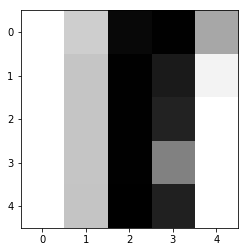

And the whole sample:


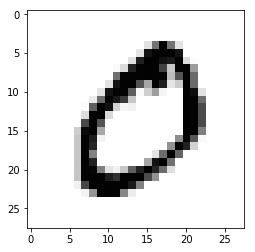

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]
(50000, 28, 28) (50000,) (10000, 28, 28) (10000, 28, 28)


In [6]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])
print(X_train.shape,y_train.shape,X_val.shape,X_test.shape)

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [7]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [8]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]] [5 0 4]


In [39]:
# run this again if you remake your graph
s = reset_tf_session()

In [27]:
# Model parameters: W and b
W = tf.get_variable("weights",shape=(784,10)) #with shape[0] = 784
b = tf.get_variable("bias",shape=(1,10))

In [40]:
# Placeholders for the input data
input_X = tf.placeholder(name="x",shape=(None,784),dtype=tf.float32) #for flat X with shape[0] = None for any batch size
input_y = tf.placeholder(name="y",shape=(None,10),dtype=tf.float32) #for one-hot encoded true labels

In [29]:
# Compute predictions
logits = input_X@W + b ### YOUR CODE HERE ### logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits=logits)### YOUR CODE HERE ### apply tf.nn.softmax to logits
classes = tf.argmax(probas,axis=1)### YOUR CODE HERE ### apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=input_y))### YOUR CODE HERE ### cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss)### YOUR CODE HERE ### optimizer step that minimizes the loss

In [42]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorN8Z%2BMfCvw78H6t8QPHOv2ulaJoWmz6hrGqXsoSGztYY2klmkY8KiIrMT2ANc18F/2i/hJ8f/D2p%2BJfhtrt80Oi332PWrTXvD99o97p83kR3AWe01CGG4h3QzRSqXjAeORXUlSDQB29FcL8D/2j/hT%2B0Zpt1rnwkvdbvdOtlhki1TUfCGp6baX8MoYxT2U95bxR38DhCyzWzSxlSpDYdSe6oAKKKKACiiigAooooAKKKKACiiigAooooAK89%2BO37UnwU/Zvk0ax%2BKXiDUxqPiKWdNA0Hw54X1HXNU1HyVV53hsdNt57mSOJWQySLGUj3puK7lz6FXg37Q/wP%2BPn/DSfg79rb9myy8H61rnh/wAHax4U1fwp451y60u0vLC/ubC7FxBe2tpePbzxTaegKm3dZUlIJQorUAGl/wDBTL9izWLvxPb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/wDBQ/8AZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/9pX4uav8AEf45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgX4X8Nay3hfxV470a58RHRfGV/8AHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhEy3qw/aTbReYCFGPUfjR/wAE6LX49fs2%2BJ/hx8Q/jn41u/HfjD4Xx%2BGde8Ut421oaPNfLaQxNqCaEt8thbs80Cyt5EUUhDyASK0jOQDpIP8AgpR%2Bxl/wrnxX8VtY%2BK17omjeCLKyvvFD%2BJ/B2r6Tc2VleTGG1vfst5axXElpLIrqlzHG0LeW5D4RiOP%2BN3/BWT9nf4Z/BDVPjH4D0XxV4qm0H4g%2BF/C%2Bu%2BGP%2BEF12x1OwOs6la2sd09nJpzXXleRcPPA3k%2BXePGlvDIZJ4wfK9U/4JifGTx38KvH2keIvA3hvRvGPiPQ9H0ew8Q6r%2B0X4z8brd2lrrFvqE0cn9uwH7BGfJYpFEsx3vhpMZJ7/wDah/YM%2BNPxg%2BIPxf8AiD4F8Q%2BF45PF8HwtvPCVnq19cxK9/wCE/EdzrUsN40dvJ5ENwGt4VljEzrl2MfyKrgHqFh/wUE/Zb1H4m2XwZh8T%2BJo/Fd5oun6xLoF38N9egudO0%2B9adILu/SSyU6dDut5VeS68pYiFEhQum6j4a/4KYfsU%2BLfBniz4haR8YLhNH8F%2BCLrxlrF7qHhLVbQXHh63Rnm1axWe1RtUs1VDiezE8bFkCsS6BsHQ/wBkP4ofEP4mfG74g/G9fD2gxfGj4O%2BHfCF1Y%2BE9duNRl0u4tE11Ltlnns7XzYwNViMT7FZikm6OPA3fN37Y37Kn7UOj/sMfFL4m/tMXfgC0h%2BEP7FPxB8EeF4/AWoXlw2vNe6RbGfUbpbm2gFioTSLcJZxtcBWmkJnbagoA%2Bs/D3/BSX9jLxNoeseI9P%2BLV1BZ6GmlTX8mqeEtVsma01K7WzsdQhS4tUa5sJZ2Ci%2BhD2qgM7Sqisw9P0T4u/DzxH8Utf%2BC%2Bh%2BIftPiTwtpen6hr9hHaTbbOC%2Ba4FrumKeUXf7LMfLVzIqhGZVWSMt8k6h%2BzP4g8V6B4p%2BNv/BSLxf8ADPwn4Ft/2e7n4dSXHh/xBMtrLpt7JDJeareTXsFulg5MFsIbZDMICZP9IkLLjsP%2BCPngP4u2f7I9r8f/ANpDUDf/ABJ%2BL15H4n8V6g9nJbtJCLSCy01fKl%2BeH/iX2lpI0TYKSzTZAYtkA%2BqqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8R0j/gox%2Bx7qV3r1nqfxSvPDzeHPDlz4g1CTxr4R1XQY5tJt3SOe/tZNStYFvrdHkiVpbYyoDLGM5dc%2B03sVzNZyw2d0IJniZYpjHv8ALYjhtp64POO9fmJq/wDwRy/bl%2BL%2BreF9c%2BN3xx0N9b8NeD9Qs9Q8Uah8VvE3iceIdb%2B2aVfWuonS76KGy0m2kudMXz7CyAURybVlkCoFAPtl/wBv/wDZhtfho3xY1jxB4q0rS21yDRrGz1z4Za/Yapqd/MhkhgstNuLFL2/aRAzr9nhkDKjsCQjEdF4D/as%2BB/xH1%2By8J%2BHPEOqQ6vf%2BFJ/EkOka14V1LTLtNNhu/sksssN5bxSQOs/yGGRVl77NvNeTfE74Oftu/GJvh78bdc8G/CrQ/iH8KPHU2seH/DNr441K/wBF1yzuNJu9MuY7i%2BfSoZrGYpeySRulrcCMxBT5gkbFX4k/Ab9uDX/jL4d/aa8D6N8K7TxZffDDVfBfjHQtS8V6lJYaQtxfw3Vrf2VwmnCTUDEI3WS3litBKXGJYscgHcaT/wAFG/2QPEeveBfC3hX4jarrOp/EnwbpXi3wbp2ieB9ZvZ7zQ9RfZa6jIkFozWtvux5kk4jW3DKZvKDAnY%2BGv7bn7N3xX%2BI1z8J/DPi/VrPX7fS7nU4bLxP4M1bRFv7G3kSOe7spdRtYI7%2BCN5Yg8ts0iL5iEkBlJ8o/YU/YS%2BLH7MOv/DjWfHniDw1dnwd%2Byl4R%2BGN%2B%2BkXM8rNq2lvM1zNF5kEe61bemxmKu235o0wK8a%2BGn/BKv9sbxP8AFHwv4m/am%2BMNnqkWn%2BAPFfhfxp4mg%2BL/AIk1q88RS6vYpbf2na6ZfQx6foRypY2lopRcqBM4jVaAPqXwn/wUX/ZH8a6LH4q0Hx3rn9h3Gq6Xp%2Bn%2BJb34f63a6VqMupXsdlZSWl9PZpbXkEtzNFGLiCR4QZULOFYE%2Bl%2BFvi78PPGvxA8U/C7wv4h%2B1654Lks4/E9olpMFsZLqD7RBGZWQRu7QlZCiMzIskZYKJE3fMPjjwJ8

# Submit a linear model

In [31]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [33]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [41]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
### YOUR CODE HERE ###
logits=tf.layers.dense(input_X,256,activation=tf.nn.relu)
probas=tf.layers.dense(logits,10,activation=tf.nn.relu)
classes = tf.argmax(probas,axis=1)
loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=probas,labels=input_y))
step=tf.train.AdamOptimizer().minimize(loss)


# Submit the MLP with 2 hidden layers
Run these cells after training the MLP with 2 hidden layers

In [43]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [44]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
